# Preliminary EDA for eICU Data

### Goals:
* Identify relevant variables 
* Explore potential transformations

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV

# Load the data
data = pd.read_csv('./raw_agg_patient_table.csv')

In [34]:
data.columns

Index(['patientunitstayid', 'patienthealthsystemstayid', 'gender', 'age',
       'ethnicity', 'hospitalid', 'wardid', 'apacheadmissiondx',
       'admissionheight', 'hospitaladmittime24', 'hospitaladmitsource',
       'hospitaldischargetime24', 'unittype', 'unitadmittime24',
       'unitadmitsource', 'unitstaytype', 'admissionweight', 'dischargeweight',
       'unitdischargetime24', 'uniquepid', 'icuduration', 'died',
       'weightdiffafterdischarge', 'intubated', 'vent', 'dialysis', 'urine',
       'wbc', 'temperature', 'respiratoryrate', 'sodium', 'heartrate',
       'meanbp', 'ph', 'creatinine', 'albumin', 'glucose', 'bilirubin', 'fio2',
       'pao2', 'pco2', 'bun', 'meanapachescore', 'meanpredictedicumortality',
       'meanpredictediculos', 'meanventdays', 'aids', 'lymphoma',
       'immunosuppression', 'diabetes', 'numbedscategory', 'teachingstatus',
       'hospitalregion', 'numberofinfusions', 'meaninfusionrate',
       'meandrugamount', 'meanvolumeoffluid', 'meannoninvasives

<BarContainer object of 10 artists>

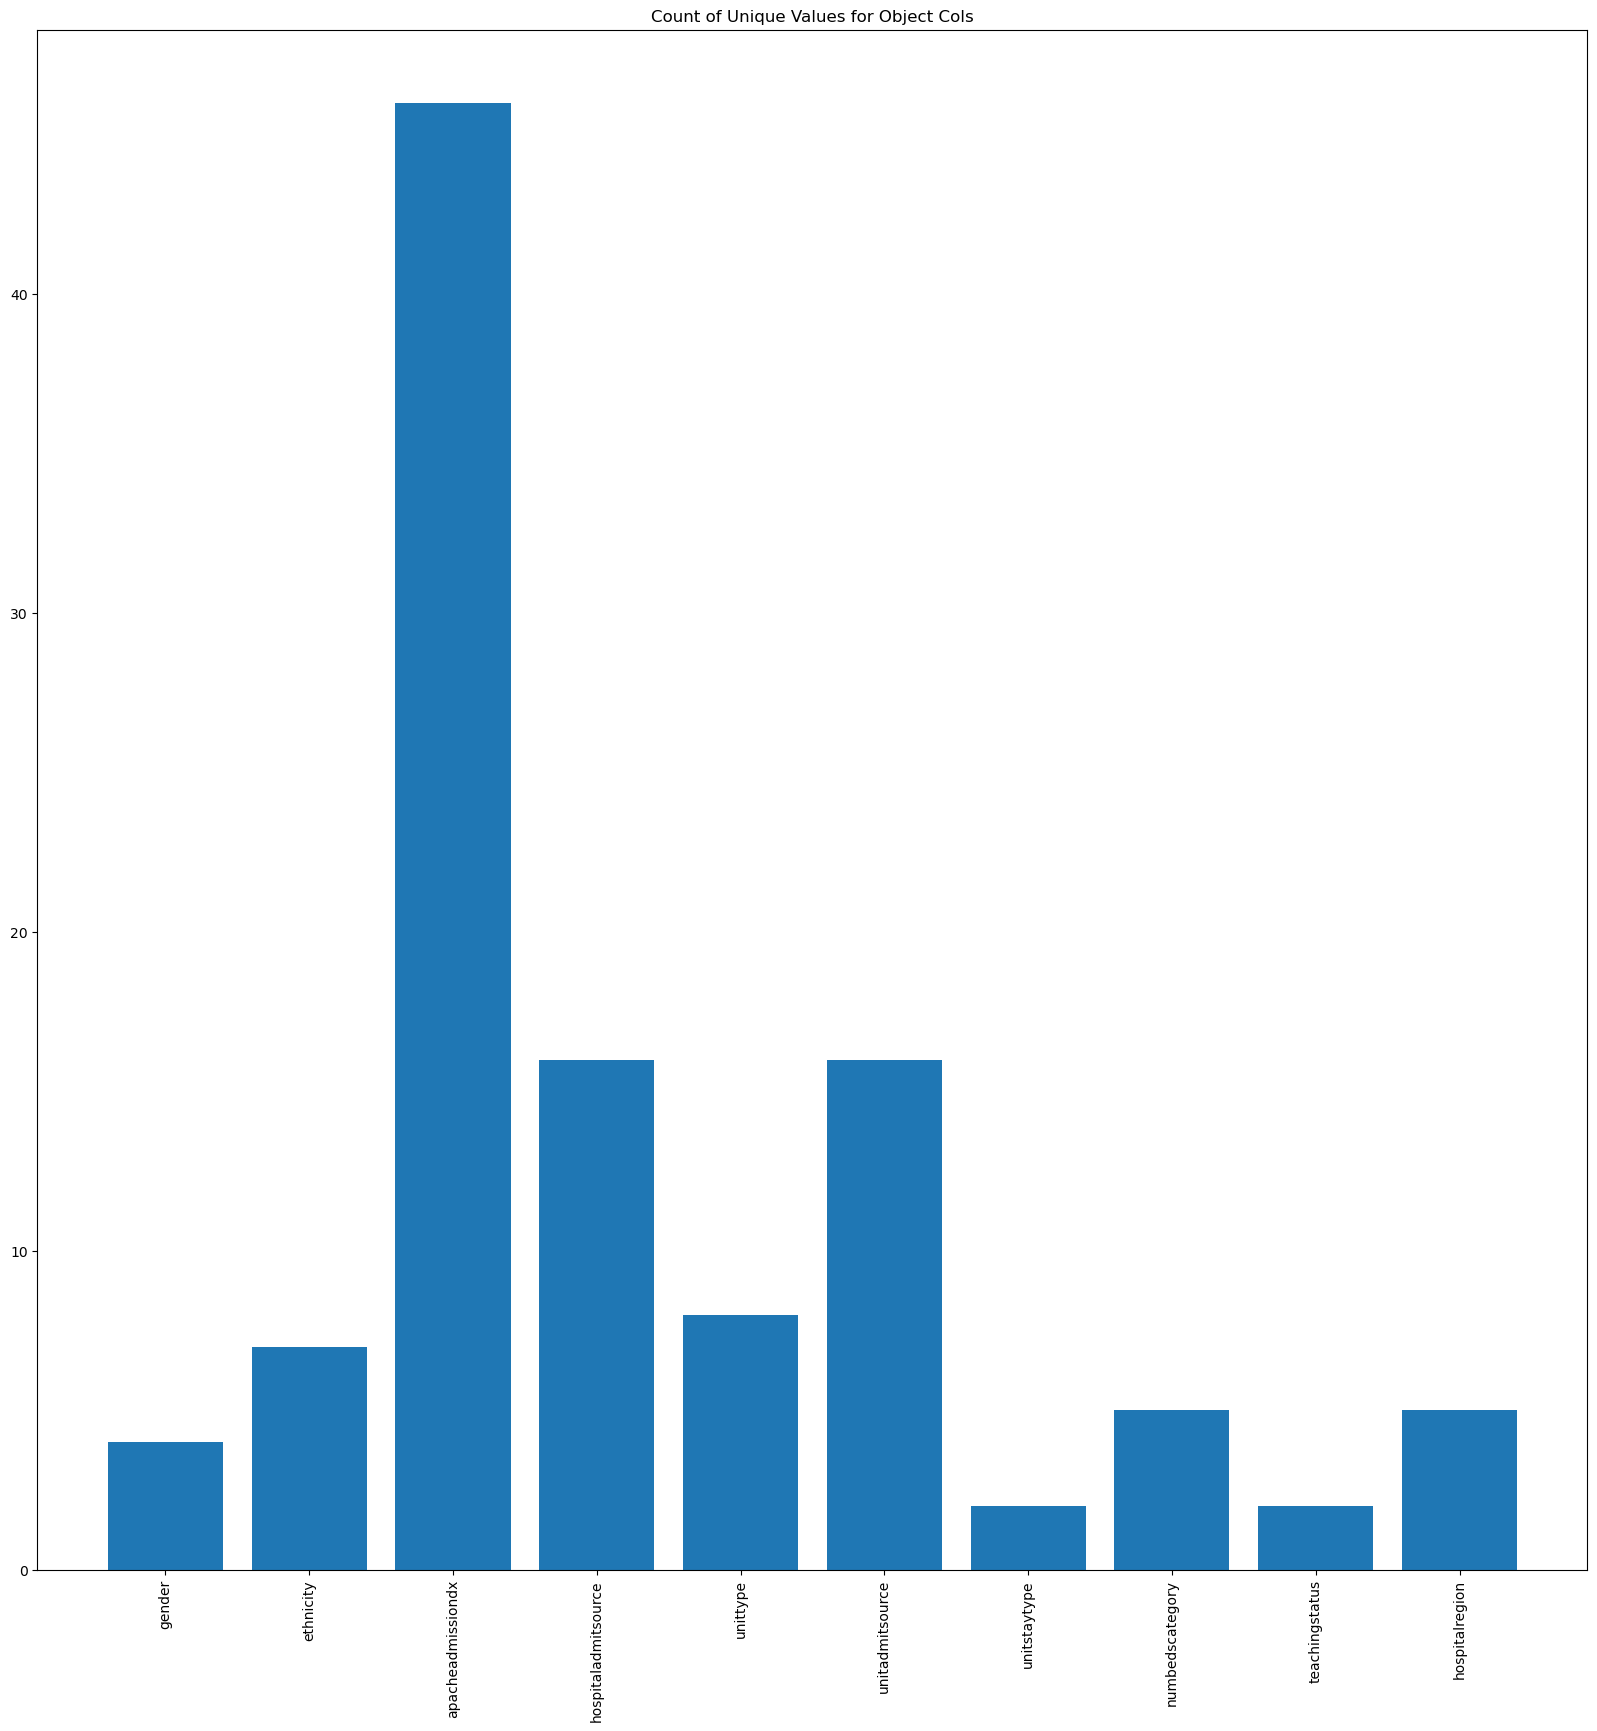

In [38]:
cols = data.columns

# _ = [print(col, data[col].dtypes) for col in cols]

unique_vals = {col:pd.unique(data[col]) for col in cols}

drop_cols = ['uniquepid',
          'hospitaladmittime24',
          'hospitaldischargetime24',
          'unitadmittime24',
          'unitdischargetime24',
         ]
data['age'] = data['age'].replace("> 89", 90).astype(float)
obj_vars = [key for key, val in unique_vals.items() if val.dtype == object and key not in drop_cols]

counts = list(len(unique_vals[name]) for name in obj_vars)
obj_vars
counts

plt.figure()
plt.xticks(rotation = 90)
plt.title("Count of Unique Values for Object Cols")
plt.bar(obj_vars, counts)

In [37]:
data['age']

0        77.0
1        59.0
2        72.0
3        46.0
4        68.0
         ... 
17162    70.0
17163    59.0
17164    59.0
17165    79.0
17166    35.0
Name: age, Length: 17167, dtype: float64

In [39]:
time_vars = [col for col in cols if "time" in col]
id_vars = [col for col in cols if "id" in col]

# Straggler 'id' columns
id_vars.remove('aids')
id_vars.remove('meanvolumeoffluid')

# # Just using to make a set difference, Time, ID, Object
tio_vars = time_vars + id_vars + obj_vars

other_vars = [col for col in cols if col not in tio_vars]
other_vars
# _ = [print(col, data[col].dtypes) for col in other_vars]

# Cleanup:
# Seems that any cols with 'dischargestatus', 'dischargelocation' are going to be variables that cause data leakage (other than predictor)
obj_vars = [o for o in obj_vars if 'dischargelocation' not in o and 'dischargestatus' not in o]

# drop_cols = [col for col in cols if 'dischargelocation' in col or 'dischargestatus' in col]

# But we want to keep this one 
obj_vars +=  ['died']
time_vars, id_vars, obj_vars, other_vars

(['hospitaladmittime24',
  'hospitaldischargetime24',
  'unitadmittime24',
  'unitdischargetime24'],
 ['patientunitstayid',
  'patienthealthsystemstayid',
  'hospitalid',
  'wardid',
  'uniquepid'],
 ['gender',
  'ethnicity',
  'apacheadmissiondx',
  'hospitaladmitsource',
  'unittype',
  'unitadmitsource',
  'unitstaytype',
  'numbedscategory',
  'teachingstatus',
  'hospitalregion',
  'died'],
 ['age',
  'admissionheight',
  'admissionweight',
  'dischargeweight',
  'icuduration',
  'died',
  'weightdiffafterdischarge',
  'intubated',
  'vent',
  'dialysis',
  'urine',
  'wbc',
  'temperature',
  'respiratoryrate',
  'sodium',
  'heartrate',
  'meanbp',
  'ph',
  'creatinine',
  'albumin',
  'glucose',
  'bilirubin',
  'fio2',
  'pao2',
  'pco2',
  'bun',
  'meanapachescore',
  'meanpredictedicumortality',
  'meanpredictediculos',
  'meanventdays',
  'aids',
  'lymphoma',
  'immunosuppression',
  'diabetes',
  'numberofinfusions',
  'meaninfusionrate',
  'meandrugamount',
  'meanvolu

### Categorical Data Analysis

For all variables that are categorical/discrete, we want to check for balance across both classification outcomes. Additionally, some transforms may be more or less appropriate

In [40]:
for o in obj_vars:
    if o != 'age':
        data[o] = data[o].astype('category') 
        # data[o] = pd.Categorical(data[o])

# _ = [print(col, data[col].dtypes) for col in obj_vars]


plot_vars = ['gender',
 'ethnicity',
 'hospitaladmitsource',
 'unittype',
 'unitstaytype',
 'numbedscategory',
 'teachingstatus',
 'hospitalregion',
 'died']

data[plot_vars]

# initial thoughts -- relatively well balanced across gender, ethnicity
# Most deaths are coming from the south, 
# 1/7 mortality vs. 1/8 from teaching vs. full time

# (pd.pivot_table(data[plot_vars], index = "gender", columns = 'dischargestatus', aggfunc = 'count') / len(data)).style.format('{:,.2%}')
# (pd.pivot_table(data[plot_vars], index = "ethnicity", columns = 'dischargestatus', aggfunc = 'count') / len(data)).style.format('{:,.2%}')
(pd.pivot_table(data[plot_vars], index = "hospitaladmitsource", columns = 'died', aggfunc = 'count') / len(data)).style.format('{:,.2%}')
(pd.pivot_table(data[plot_vars], index = "teachingstatus", columns = 'died', aggfunc = 'count') / len(data)).style.format('{:,.2%}')
# (pd.pivot_table(data[plot_vars], index = "hospitalregion", columns = 'dischargestatus', aggfunc = 'count') / len(data)).style.format('{:,.2%}')

### Numerical Data Analysis

Generally seek to confirm of (approximate) multivariate normal for variable selection/etc; may not be relevant for more ml techniques like lasso

Without domain specific knowledge, difficult to say about the data integrity for some of the variables; however, for admission weight, height, I think it unlikely that someone is 600 cm tall and another patient weights 340 KG (750 lb) when admitted and was discharged at 370 KG!

Other Notes:

* PH should have a max of 14
* What does icuduration represent?
* Supposed binary Values:
* - Intubated
* - vent
* - aids
* - lymphoma
* - immunosuppression



In [41]:
drop_cols

['uniquepid',
 'hospitaladmittime24',
 'hospitaldischargetime24',
 'unitadmittime24',
 'unitdischargetime24']

/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_12603/2444408920.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric['died'] = data['died'].astype('float')


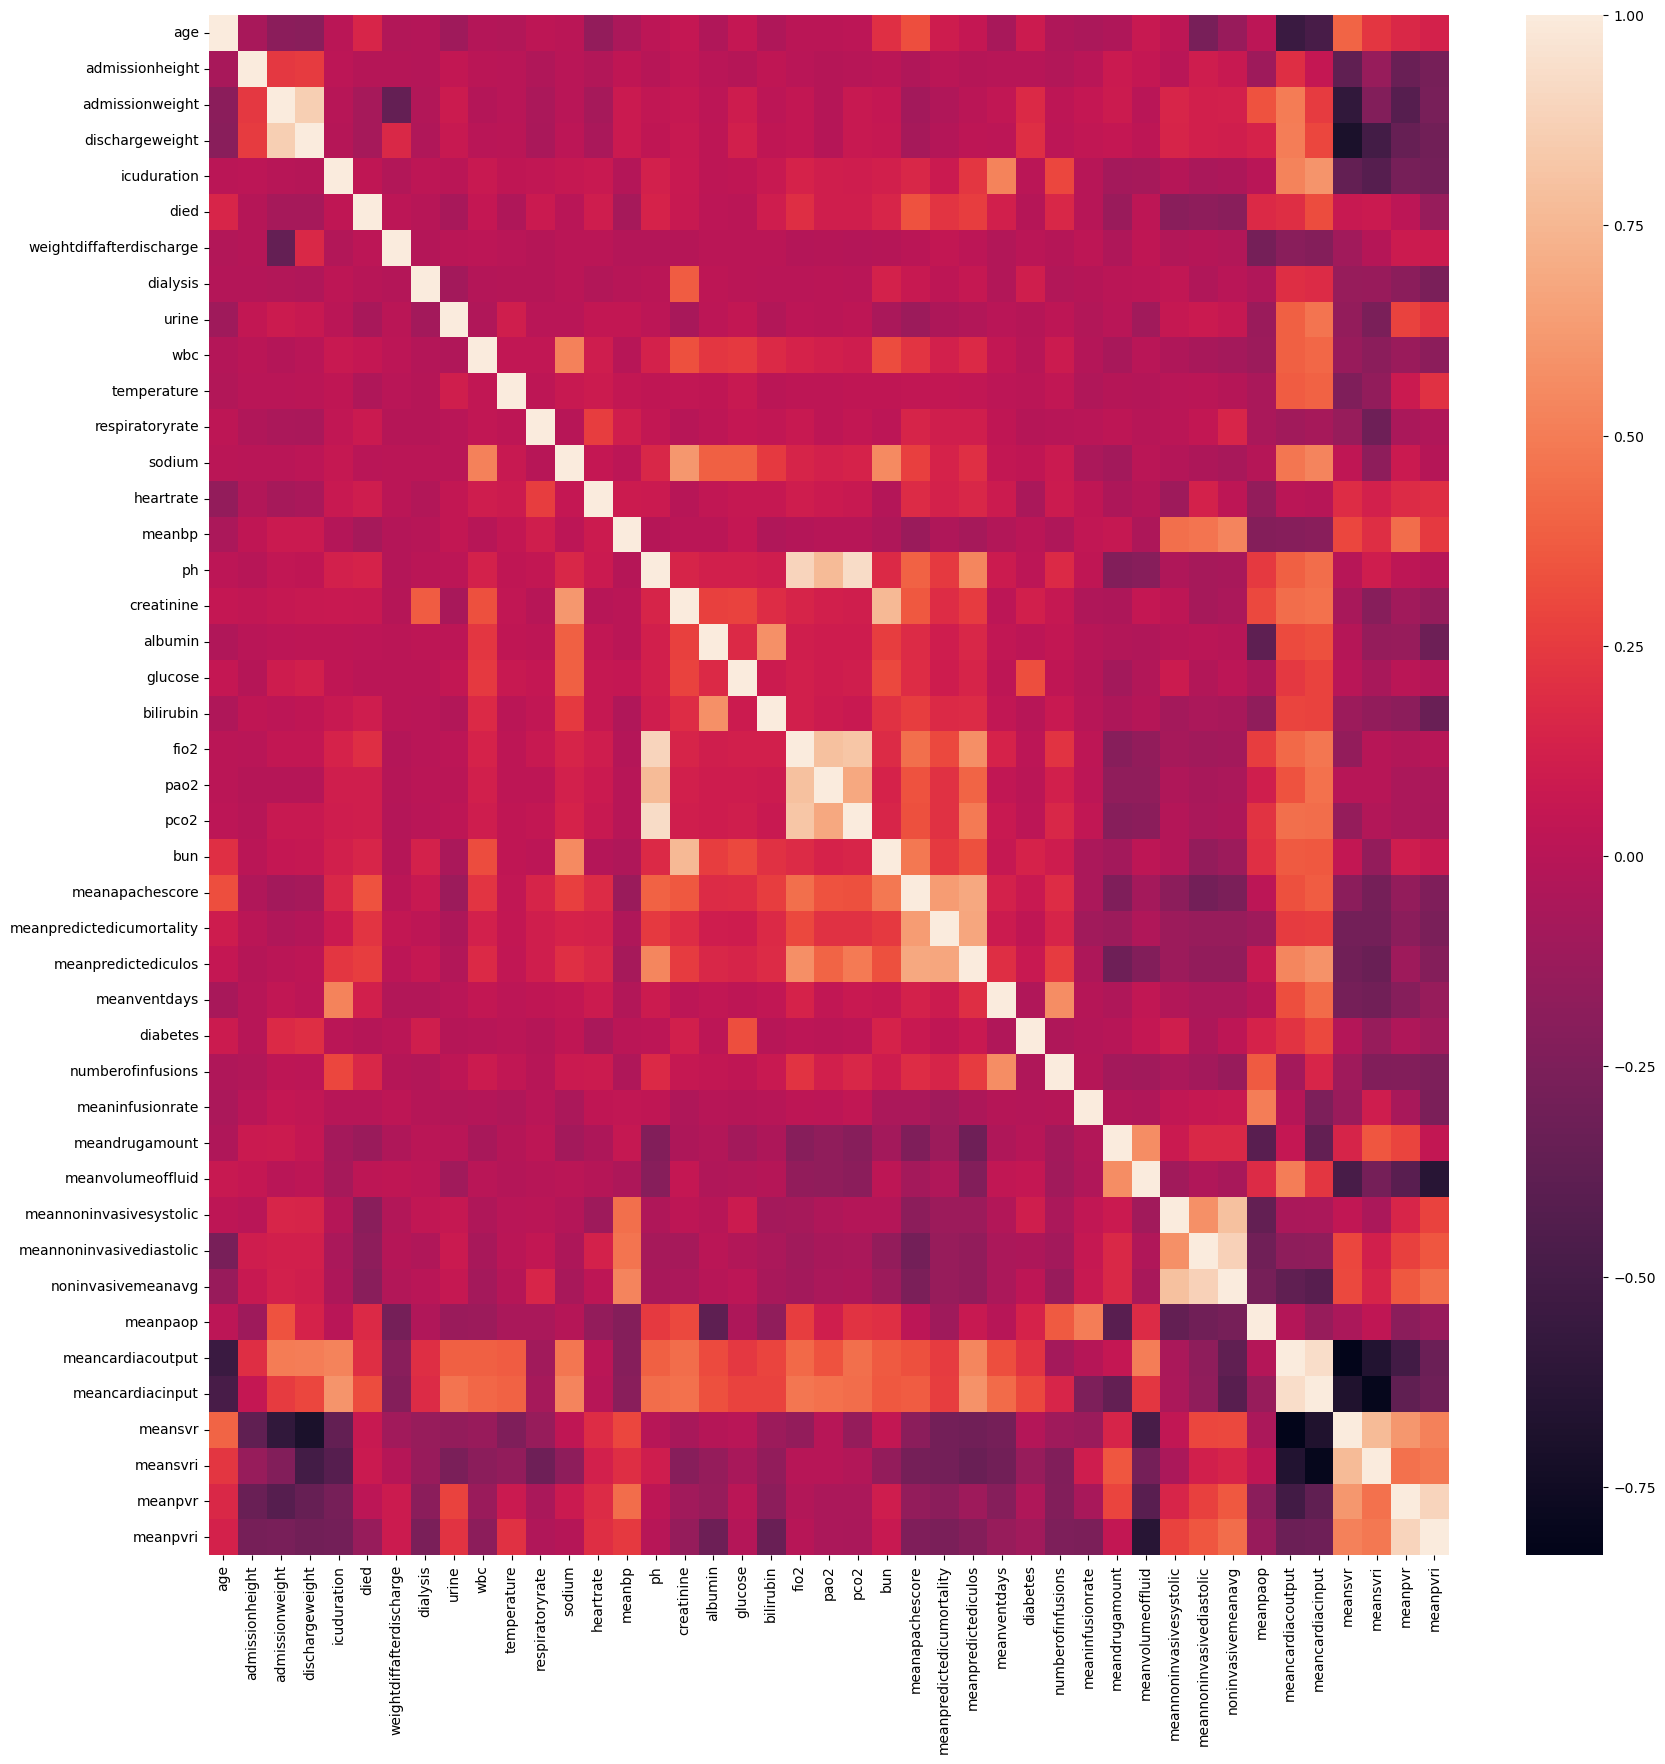

In [42]:
import seaborn as sns


binaries = ['intubated', 'vent', 'aids', 'lymphoma', 'immunosuppression']
plot_vars = [var for var in other_vars if var not in binaries] 

numeric = data[plot_vars]

numeric['died'] = data['died'].astype('float')
 

# for o in other_vars:
#     print(data[o].describe())

ax = sns.heatmap(numeric.corr(), annot=False)


Generic PCA for variable selection

In [43]:
scaler = StandardScaler()

numeric = numeric.fillna(0)

numeric_scaled = scaler.fit_transform(numeric)

pca = PCA(n_components = 10).fit(numeric_scaled)

numeric_pca = pca.fit(numeric_scaled)

covmat = pca.get_covariance()

# plt.plot(covmat)

# numeric_pca.feature_names_in_



/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_12603/2329761534.py:17: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_ticklabels([])
/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_12603/2329761534.py:19: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_ticklabels([])
/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_12603/2329761534.py:21: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_ticklabels([])


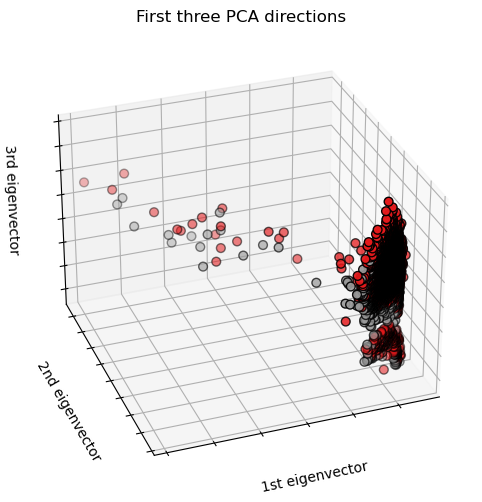

In [44]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

X_reduced = pca.fit_transform(numeric_scaled)
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=data['died'],
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

Histograms

ValueError: num must be 1 <= num <= 40, not 41

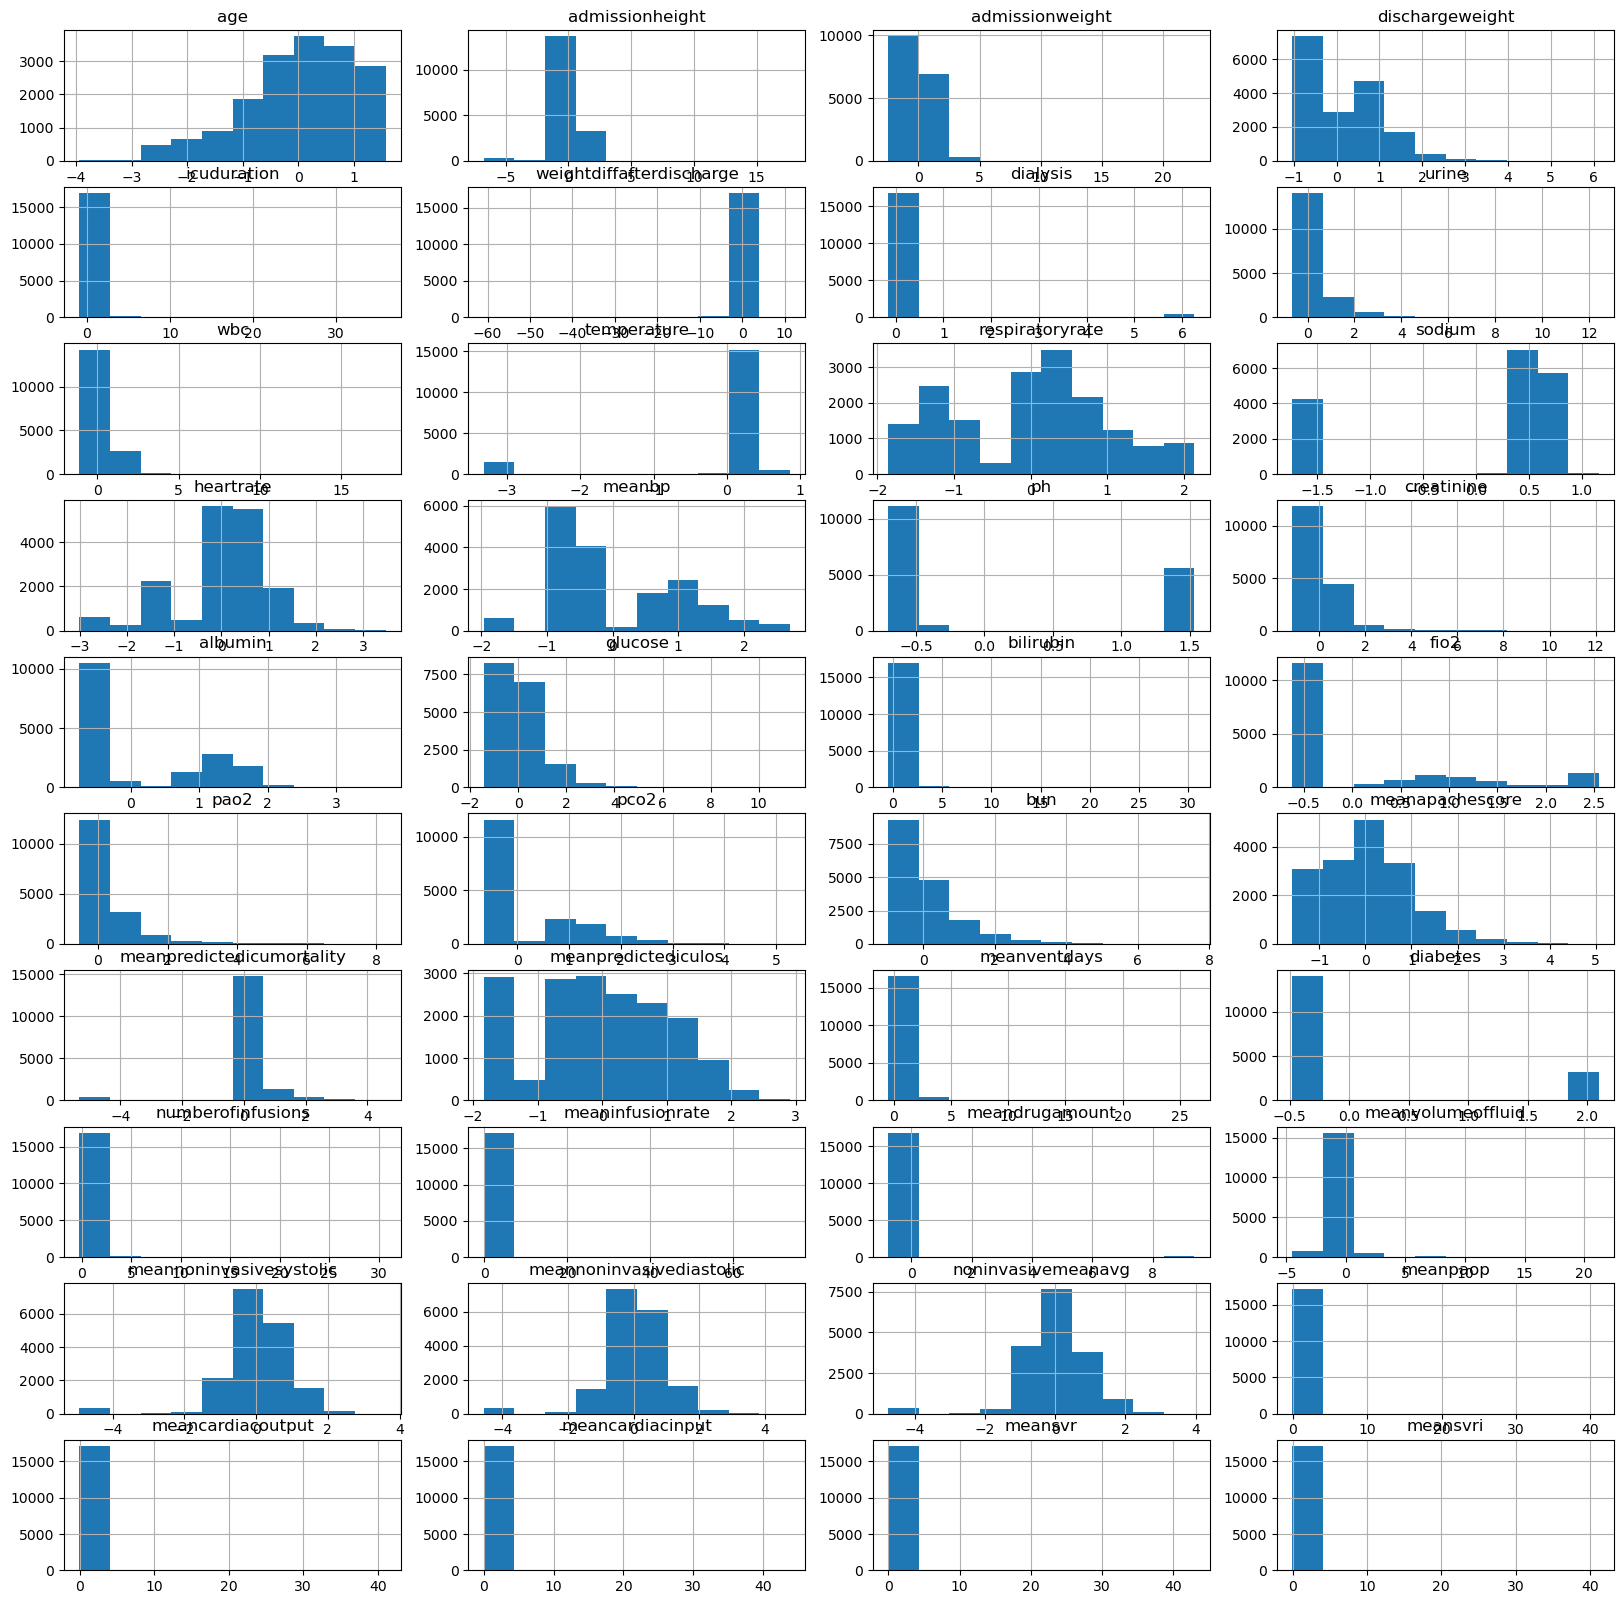

In [45]:
plt.rcParams['figure.figsize'] = [20, 20]

fig=plt.figure()

numeric_charts = pd.DataFrame(numeric_scaled, columns= numeric.columns).drop(columns = "died")
numeric_charts.columns

for i, n in enumerate(numeric_charts.columns[:-1]): 
    ax=fig.add_subplot(10, 4, i+1)
    numeric_charts[n].hist(ax=ax)
    ax.set_title(n)

fig.tight_layout()

### Lasso for feature selection

One hot encoding

In [61]:
enc = OneHotEncoder()

Y = data['died'].to_numpy()
X_data = data.drop(columns = ['died'] + time_vars + drop_cols)

type_list = X_data.dtypes.tolist()
str_index = [i for i in range(len(type_list)) if type_list[i] == 'category']
num_index = [i for i in range(len(type_list)) if type_list[i] != 'category']

enc_data= OneHotEncoder(handle_unknown='ignore', drop = "first")
X_transformed = enc_data.fit_transform(X_data.iloc[:,str_index]).toarray()



X = np.nan_to_num(np.concatenate([np.array(X_data.iloc[:, num_index]), X_transformed], axis=1))

# X = X_transformed

In [74]:
Y = np.nan_to_num(Y)

In [77]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb 
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 0)

x_train_scaled = StandardScaler().fit_transform(X_train)


np.any(np.isnan(x_train_scaled))

gbc_pipe = Pipeline([('scaler', StandardScaler()), ('clf', GradientBoostingClassifier())])

gbc_pipe.fit(X_train, y_train)

gbc_pipe.score(X_test, y_test)


0.8946877912395154

In [81]:
1 - sum(Y) / len(Y)

0.8783712937612862

Not doing much better than a naive predictor that everyone survives. Likely need to do more feature engineering (there were values of -1 for several of the numeric features that could need to be modified)